# 19th

## Probabilistic model

Epoch 01/100  loss 0.0007
Epoch 05/100  loss 0.0008
Epoch 10/100  loss 0.0020
Epoch 15/100  loss 0.0007
Epoch 20/100  loss 0.0018
Epoch 25/100  loss 0.0032
Epoch 30/100  loss 0.0014
Epoch 35/100  loss 0.0002
Epoch 40/100  loss 0.0000
Epoch 45/100  loss 0.0042
Epoch 50/100  loss 0.0008
Epoch 55/100  loss 0.0004
Epoch 60/100  loss 0.0118
Epoch 65/100  loss 0.0004
Epoch 70/100  loss 0.0005
Epoch 75/100  loss 0.0019
Epoch 80/100  loss 0.0017
Epoch 85/100  loss 0.0007
Epoch 90/100  loss 0.0000
Epoch 95/100  loss 0.0013
Epoch 100/100  loss 0.0085

Hold-out RMSE: 2.649755


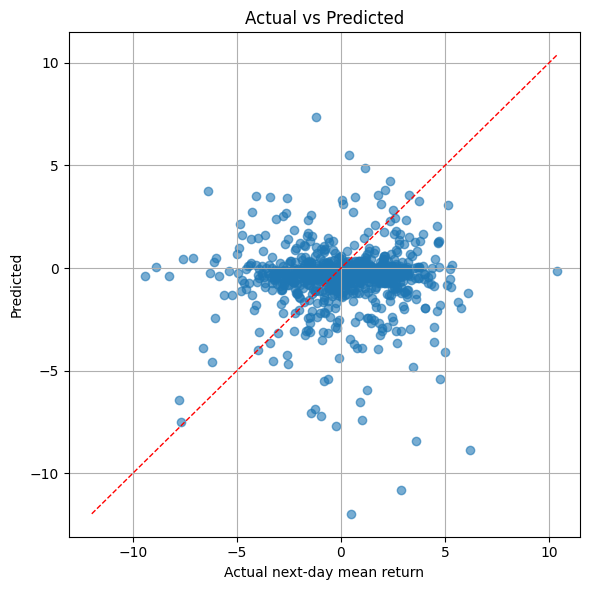

In [1]:
# prob_model_simplified.py
# ------------------------
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

CSV        = '../../data/dataV.csv'
WIN        = 10
TRAIN_FRAC = 0.8
BATCH      = 32
EPOCHS     = 100
LR         = 1e-3
device     = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1) Load & features ----------------------------------------------------------
df = (pd.read_csv(CSV, parse_dates=['Date'])
        .sort_values('Date')
        .reset_index(drop=True))

v = df['returns'].astype('float32')
df['sd']      = v.rolling(WIN).std(ddof=1)
df['sd_mean'] = df['sd'].rolling(WIN).mean()
df = df.dropna(subset=['returns', 'sd', 'sd_mean']).reset_index(drop=True)
feat_cols = ['sd', 'returns', 'sd_mean']

# 2) Chronological split ------------------------------------------------------
split   = int(len(df) * TRAIN_FRAC)
train_d = df.iloc[:split].copy()
test_d  = df.iloc[split:].copy()

# 3) Fit scalers on TRAIN ONLY -----------------------------------------------
scaler_X = StandardScaler().fit(train_d[feat_cols])
scaler_y = StandardScaler().fit(train_d[['returns']])

for frame in (train_d, test_d):
    frame[feat_cols] = scaler_X.transform(frame[feat_cols]).astype('float32')
    frame['returns'] = scaler_y.transform(frame[['returns']]).astype('float32')

# 4) Dataset / loaders --------------------------------------------------------
class SeqDataset(Dataset):
    def __init__(self, frame):
        X, y = frame[feat_cols].to_numpy(np.float32), frame['returns'].to_numpy(np.float32)
        self.samples = [(X[i:i+WIN], y[i+WIN]) for i in range(len(frame)-WIN-1)]
    def __len__(self):  return len(self.samples)
    def __getitem__(self, k):
        x, y = self.samples[k]
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32)

train_dl = DataLoader(SeqDataset(train_d), batch_size=BATCH, shuffle=True)
test_dl  = DataLoader(SeqDataset(test_d),  batch_size=BATCH)

# 5) Model --------------------------------------------------------------------
class LSTM1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(3, 64, batch_first=True)
        self.fc   = nn.Linear(64, 1)
    def forward(self, x):
        return self.fc(self.lstm(x)[0][:, -1])

model = LSTM1().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
crit  = nn.MSELoss()

# 6) Train --------------------------------------------------------------------
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        loss = crit(model(xb), yb)
        opt.zero_grad(); loss.backward(); opt.step()
    if ep % 5 == 0 or ep == 1:
        print(f'Epoch {ep:02d}/{EPOCHS}  loss {loss.item():.4f}')

# 7) Predict / inverse-scale --------------------------------------------------
model.eval(); P_s, T_s = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        P_s.append(model(xb.to(device)).cpu())
        T_s.append(yb)
P = scaler_y.inverse_transform(torch.cat(P_s).numpy())
T = scaler_y.inverse_transform(torch.cat(T_s).numpy())

rmse = np.sqrt(mean_squared_error(T, P))
print(f'\nHold-out RMSE: {rmse:.6f}')

# 8) Plot Actual vs Pred ------------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(T, P, alpha=.6)
lims = [min(T.min(), P.min()), max(T.max(), P.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel('Actual next-day mean return')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# 9) Save predictions back to CSV (optional) ----------------------------------
df.loc[test_d.index[-len(P):], 'ProbL_pred'] = P.ravel()
df.to_csv(CSV, index=False, float_format='%.6f')


## Hyper-parameters tunning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

import torch
import torch.nn as nn

# ---- skorch wrapper (pip install skorch) ----
from skorch import NeuralNetRegressor


# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# 2) Encode Date as numeric
df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

# 3) Features & target
feature_cols = [
    'Date_ordinal',
    'Inflation',
    'CPI',
    'Treasury_Yield',
    'Close',
    'SP500_Adj_Close',
    'Volume',
    'GDP',
    'mortage',
    'unemployement',
    'fed_fund_rate',
    'volatility',
    'returns',
    'EWMA_VM',
    'GARCH_VM',
    'EGARCH_VM',
    'RogersSatchell_VM',
    'garman_klass',
    'parkinson',
    'yang_zhang',
    'move'
]

target_col = 'volatility_forcast'

X_raw = df[feature_cols].values
y_raw = df[[target_col]].values


# 4) Standard scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

train_idx = int(0.8 * len(X_raw))
scaler_X.fit(X_raw[:train_idx])
scaler_y.fit(y_raw[:train_idx])

# 5) Sliding‐window sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t, :])
        ys.append(y[t, :])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 6) Train/test split (no shuffle to respect chronology)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# 7) Define LSTM model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=len(feature_cols),
                 hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim,
                             hidden_size=hidden_dim1,
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1,
                             hidden_size=hidden_dim2,
                             num_layers=1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        last = out2[:, -1, :]
        return self.fc(last)

# 8) Wrap with skorch NeuralNetRegressor
net = NeuralNetRegressor(
    module=LSTMForecast,
    module__input_dim=len(feature_cols),
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    max_epochs=50,
    batch_size=128,          # will be tuned
    optimizer__lr=1e-3,      # will be tuned
    train_split=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# 9) Hyperparameter search space
param_dist = {
    'module__hidden_dim1': randint(32, 256),
    'module__hidden_dim2': randint(32, 128),
    'batch_size': randint(32, 256),
    'optimizer__lr': loguniform(1e-4, 1e-2),
}

# 10) RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1,
)

# skorch/torch expects float32
rs.fit(X_train.astype(np.float32), y_train.astype(np.float32))

print("Best parameters:", rs.best_params_)
print("Best CV MSE:", -rs.best_score_)

# 11) Evaluate on the chronological hold-out set
best_model = rs.best_estimator_

y_pred_scaled = best_model.predict(X_test.astype(np.float32))
y_test_scaled = y_test

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = max(0.0, r2_score(y_test_orig, y_pred))

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


In [ ]:
import matplotlib.pyplot as plt
# ---------------------------
# 11) Plot the loss curve
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_epochs + 1), train_losses, linewidth=2)
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
"""
LSTM volatility forecasting with hyper-parameter tuning via
RandomizedSearchCV + skorch wrapper around a PyTorch model.

✓  Uses StandardScaler on X and y (fit once on the whole sequence matrix)
✓  Converts all predictions back to the raw scale before metrics / plots
✓  Keeps TimeSeriesSplit chronology for cross-validation
"""

# -------------------------------------------------------------------
# 1) Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

import torch
import torch.nn as nn
from skorch import NeuralNetRegressor

import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 2) Load & sort data
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# -------------------------------------------------------------------
# 3) Encode Date numerically + select columns
# -------------------------------------------------------------------
df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

feature_cols = [
    'Date_ordinal', 'Inflation', 'CPI', 'Treasury_Yield', 'Close',
    'SP500_Adj_Close', 'Volume', 'GDP', 'mortage', 'unemployement',
    'fed_fund_rate', 'volatility', 'returns',
    'EWMA_VM', 'GARCH_VM', 'EGARCH_VM', 'RogersSatchell_VM',
    'garman_klass', 'parkinson', 'yang_zhang', 'move'
]
target_col = 'volatility_forcast'

# raw 2-D matrices --------------------------------------------------
X_raw = df[feature_cols].values.astype(np.float32)
y_raw = df[[target_col]].values.astype(np.float32)

# -------------------------------------------------------------------
# 4) Standard scaling (fit once, then transform)
#     – features and target scaled *independently*
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw).astype(np.float32)
y_scaled = scaler_y.fit_transform(y_raw).astype(np.float32)

# -------------------------------------------------------------------
# 5) Sliding-window sequences (seq_len historical steps → 1 target)
# -------------------------------------------------------------------
def create_sequences(X, y, seq_len: int):
    """Return arrays shaped (N, seq_len, n_features) and (N, 1)."""
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t - seq_len:t, :])
        ys.append(y[t, :])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# -------------------------------------------------------------------
# 6) Chronological train / test split (80 % / 20 %)
# -------------------------------------------------------------------
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# -------------------------------------------------------------------
# 7) LSTM model definition
# -------------------------------------------------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_dim: int, hidden_dim1: int = 128, hidden_dim2: int = 64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim,
                             hidden_size=hidden_dim1,
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1,
                             hidden_size=hidden_dim2,
                             num_layers=1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        last = out2[:, -1, :]          # shape: (batch, hidden_dim2)
        return self.fc(last)           # shape: (batch, 1)

# -------------------------------------------------------------------
# 8) Wrap with skorch NeuralNetRegressor
# -------------------------------------------------------------------
net = NeuralNetRegressor(
    module=LSTMForecast,
    module__input_dim=len(feature_cols),
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    max_epochs=50,
    batch_size=128,            # will be tuned
    optimizer__lr=1e-3,        # will be tuned
    train_split=None,          # CV handled outside via TimeSeriesSplit
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# -------------------------------------------------------------------
# 9) Hyper-parameter search space
# -------------------------------------------------------------------
param_dist = {
    'module__hidden_dim1': randint(4, 128),
    'module__hidden_dim2': randint(2, 64),
    'batch_size':           randint(8, 256),
    'optimizer__lr':        loguniform(1e-4, 1e-2),
}

# -------------------------------------------------------------------
# 10) RandomizedSearchCV with time-series aware folds
# -------------------------------------------------------------------
tscv = TimeSeriesSplit(n_splits=3)

rs = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_dist,
    n_iter=1000,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1,
)

# skorch / torch need float32
rs.fit(X_train, y_train)

print("Best parameters:", rs.best_params_)
print("Best CV MSE:    ", -rs.best_score_)

# -------------------------------------------------------------------
# 11) Evaluate on the hold-out set (convert back to raw units)
# -------------------------------------------------------------------
best_model = rs.best_estimator_

# Predict → unscale
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test)

# Metrics
mse  = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_orig, y_pred)
r2   = max(0.0, r2_score(y_test_orig, y_pred))

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")

# -------------------------------------------------------------------
# 12) Plot training loss vs. epoch
# -------------------------------------------------------------------
history      = best_model.history
train_losses = [row['train_loss'] for row in history]
n_epochs     = len(train_losses)

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_epochs + 1), train_losses, linewidth=2)
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 13) Scatter plot: actual vs. predicted (original scale)
# -------------------------------------------------------------------
plt.figure(figsize=(8, 8))
plt.scatter(y_test_orig, y_pred, alpha=0.6, label="Predicted")
axis_min = min(y_test_orig.min(), y_pred.min())
axis_max = max(y_test_orig.max(), y_pred.max())
plt.plot([axis_min, axis_max], [axis_min, axis_max],
         color='red', linestyle='--', label="Ideal")
plt.title("Predicted vs. Actual Volatility")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Option pricing model

### LSTM vol calculation

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------------------------------------------------
# 1) Load & sort
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility']].values                # shape: (T, 1)
y_raw = df[['volatility_forcast']].values        # shape: (T, 1)

# -------------------------------------------------------------------
# 2) Scale
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# -------------------------------------------------------------------
# 3) Build fixed-length sequences
# -------------------------------------------------------------------
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t - seq_len:t])
        ys.append(y[t])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# -------------------------------------------------------------------
# 4) Chronological train / test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# -------------------------------------------------------------------
# 5) DataLoaders
# -------------------------------------------------------------------
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False
)

# -------------------------------------------------------------------
# 6) Two-layer LSTM model (64 → 32) + 1 FC output
# -------------------------------------------------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=1, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        out2 = self.dropout(out2)
        last = out2[:, -1, :]
        return self.fc(last)

device   = 'cuda' if torch.cuda.is_available() else 'cpu'
model    = LSTMForecast().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# -------------------------------------------------------------------
# 7) Training loop
# -------------------------------------------------------------------
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch:3d}/{n_epochs} — train MSE: {epoch_loss/len(train_loader.dataset):.6f}")

# -------------------------------------------------------------------
# 8) Evaluation on the hold-out set
# -------------------------------------------------------------------
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds.append(model(Xb).cpu().numpy())
        trues.append(yb.numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse scale to original units
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = max(0.0, r2_score(y_test, y_pred))

print("\nEvaluation on test set")
print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")

# -------------------------------------------------------------------
# 9) Predict for the *entire* series & save to CSV
# -------------------------------------------------------------------
with torch.no_grad():
    X_all_tensor = torch.from_numpy(X_seq).to(device)
    all_scaled   = model(X_all_tensor).cpu().numpy()

all_pred = scaler_y.inverse_transform(all_scaled).squeeze()

# create the new column (NaN for the first SEQ_LEN rows that have no sequence)
df['LSTM_vol'] = np.nan
df.loc[SEQ_LEN:, 'LSTM_vol'] = all_pred

# write to a new file; change the path to overwrite if desired
output_path = '../../data/dataV.csv'
df.to_csv(output_path, index=False)
print(f"\nSaved predictions to '{output_path}' (column: LSTM_vol)")


Epoch   1/100 — train MSE: 0.754475
Epoch   2/100 — train MSE: 0.635679
Epoch   3/100 — train MSE: 0.618486
Epoch   4/100 — train MSE: 0.606570
Epoch   5/100 — train MSE: 0.610886
Epoch   6/100 — train MSE: 0.599315
Epoch   7/100 — train MSE: 0.592766
Epoch   8/100 — train MSE: 0.596540
Epoch   9/100 — train MSE: 0.594197
Epoch  10/100 — train MSE: 0.589831
Epoch  11/100 — train MSE: 0.588343
Epoch  12/100 — train MSE: 0.589315
Epoch  13/100 — train MSE: 0.582393
Epoch  14/100 — train MSE: 0.575975
Epoch  15/100 — train MSE: 0.579831
Epoch  16/100 — train MSE: 0.583587
Epoch  17/100 — train MSE: 0.574253
Epoch  18/100 — train MSE: 0.573119
Epoch  19/100 — train MSE: 0.577159
Epoch  20/100 — train MSE: 0.567426
Epoch  21/100 — train MSE: 0.565013
Epoch  22/100 — train MSE: 0.577259
Epoch  23/100 — train MSE: 0.573048
Epoch  24/100 — train MSE: 0.564387
Epoch  25/100 — train MSE: 0.562125
Epoch  26/100 — train MSE: 0.573172
Epoch  27/100 — train MSE: 0.575840
Epoch  28/100 — train MSE: 0

### LSTM-EMD VOL calculation

first 20 EMD windows: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
X_dyn: (1051, 20, 1) M_dyn: (1051, 20, 1) y_dyn: (1051,)
Epoch 1/100 — train MSE: 0.072936 — val MSE: 0.026185
Epoch 2/100 — train MSE: 0.029058 — val MSE: 0.009941
Epoch 3/100 — train MSE: 0.016795 — val MSE: 0.004205
Epoch 4/100 — train MSE: 0.011455 — val MSE: 0.005516
Epoch 5/100 — train MSE: 0.010816 — val MSE: 0.005695
Epoch 6/100 — train MSE: 0.010061 — val MSE: 0.005357
Epoch 7/100 — train MSE: 0.009869 — val MSE: 0.005483
Epoch 8/100 — train MSE: 0.009913 — val MSE: 0.005188
Epoch 9/100 — train MSE: 0.009949 — val MSE: 0.005340
Epoch 10/100 — train MSE: 0.009764 — val MSE: 0.005238
Epoch 11/100 — train MSE: 0.009871 — val MSE: 0.004906
Epoch 12/100 — train MSE: 0.010028 — val MSE: 0.005411
Epoch 13/100 — train MSE: 0.009954 — val MSE: 0.004708
Epoch 14/100 — train MSE: 0.009693 — val MSE: 0.004975
Epoch 15/100 — train MSE: 0.009708 — val MSE: 0.005082
Epoch 16/100 — train MSE: 0.010035 — val MS

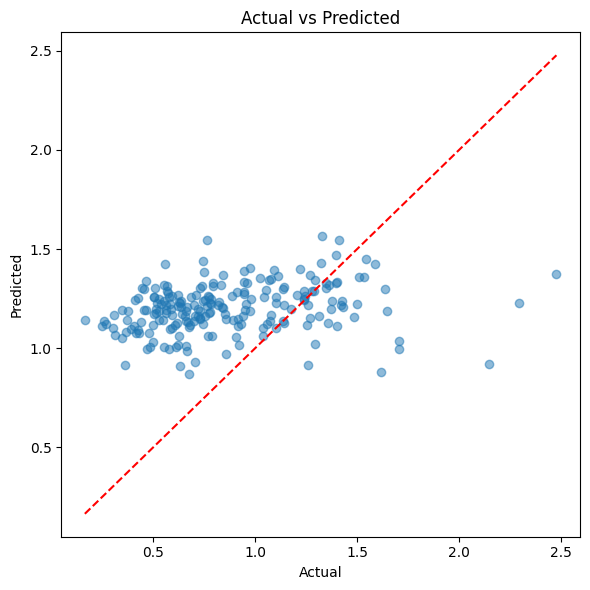

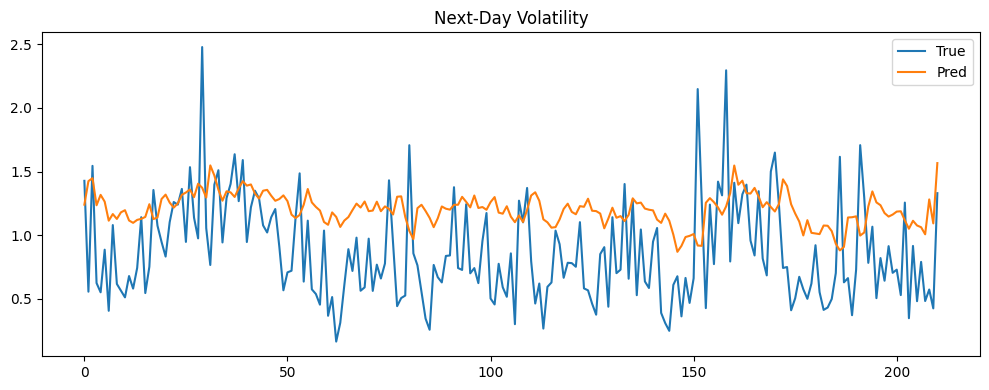

In [2]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from PyEMD import EMD
from scipy.signal import hilbert

import torch
import torch.nn as nn
import torch.optim as optim

# %%
# 1) Load & scale
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)
X_raw = df[['volatility']].values    # shape (T,1)
y_raw = df[['volatility_forcast']].values  # shape (T,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).flatten()  # make it (T,) for easier indexing


# %%
# 2) Compute EMD‐based window sizes τₜ
max_W = 20
emd     = EMD()

imfs    = emd.emd(X_scaled.flatten())    # must pass a 1-D array
all_amp = [ np.abs(hilbert(imf)) for imf in imfs ]
all_pow = [ amp**2 for amp in all_amp ]
energies = [ p.mean() for p in all_pow ]

inst_power_norm = np.zeros_like(X_scaled.flatten(), dtype=float)
for p, E in zip(all_pow, energies):
    inst_power_norm += (p / E)

tau_emd = np.clip(np.round(inst_power_norm).astype(int), 1, max_W)
print("first 20 EMD windows:", tau_emd[:20])


# %%
# --- 3) Build dynamic sequences + mask, now also returning the original row‐indices ---
def create_dynamic_sequences_with_mask(X, y, tau, max_len):
    Xs, masks, ys, idxs = [], [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w:
            continue

        window = X[t-w : t]       # shape (w, D)
        m      = np.ones((w,1))
        if w < max_len:
            pad_X = np.zeros((max_len - w, D))
            pad_m = np.zeros((max_len - w, 1))
            window = np.vstack([pad_X, window])
            m      = np.vstack([pad_m,    m     ])

        Xs.append(window)         # → (max_len, D)
        masks.append(m)           # → (max_len, 1)
        ys.append(y[t])           # scalar target
        idxs.append(t)            # record that this sample “ends” at original row t
    return np.stack(Xs), np.stack(masks), np.array(ys), np.array(idxs)

X_dyn, M_dyn, y_dyn, idx_dyn = create_dynamic_sequences_with_mask(
    X_scaled,    # (T,1)
    y_scaled,    # (T,)
    tau_emd,     # (T,)
    max_W        # scalar
)

print("X_dyn:", X_dyn.shape, "M_dyn:", M_dyn.shape, "y_dyn:", y_dyn.shape)
# X_dyn = (N, max_W, D), M_dyn = (N, max_W, 1), y_dyn = (N,)


# %%
# 4) Concatenate mask as extra feature
X_with_mask = np.concatenate([X_dyn, M_dyn], axis=2)
# now shape = (N, max_W, D+1)

# %%
# --- 5) Train/test split, now also splitting idx_dyn to get test_idx ---

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_with_mask,    # features
    y_dyn,          # targets
    idx_dyn,        # row‐indices in df
    test_size=0.2,
    shuffle=False
)


# %%
# 6) Broadcast each scalar target into a seq‐length long vector
def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    Y = np.zeros((N, seq_length, 1))
    for i, val in enumerate(y_flat):
        Y[i, :, 0] = val
    return Y

Y_train = build_y_seqs(y_train, max_W)
Y_test  = build_y_seqs(y_test,  max_W)

# %%

class MaskedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        """
        Same API as before:
          - input_dim   = D (number of “real” features per time step)
          - hidden_dim1 = 256
          - hidden_dim2 = 128
          - output_dim  = 1

        Internally, we just stack two nn.LSTMCell modules, and before
        each time step we “hard‐forget” by multiplying h and c by mask_t.
        """
        super().__init__()
        self.input_dim  = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim

        # Layer‐1: input→256
        self.cell1 = nn.LSTMCell(input_dim, hidden_dim1)
        # Layer‐2: 256→128
        self.cell2 = nn.LSTMCell(hidden_dim1, hidden_dim2)
        # Final linear: 128→output_dim
        self.out   = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x_with_mask):
        """
        x_with_mask: (batch, seq_len, input_dim+1)
          – last channel is the 0/1 mask
          – first input_dim channels are the “real” features.
        Returns: y_preds of shape (batch, seq_len, output_dim)
        """
        batch, seq_len, Dp = x_with_mask.size()
        assert Dp == self.input_dim + 1

        data = x_with_mask[:, :, :-1]  # (batch, seq_len, input_dim)
        mask = x_with_mask[:, :, -1:]  # (batch, seq_len, 1)

        # initialize h1,c1 and h2,c2 to zero:
        h1 = data.new_zeros(batch, self.hidden_dim1)
        c1 = data.new_zeros(batch, self.hidden_dim1)
        h2 = data.new_zeros(batch, self.hidden_dim2)
        c2 = data.new_zeros(batch, self.hidden_dim2)

        outs = []
        for t in range(seq_len):
            x_t = data[:, t, :]     # (batch, input_dim)
            m_t = mask[:, t, :]     # (batch, 1); either 0.0 or 1.0

            # —— Layer 1 “hard‐forget” step:
            h1 = h1 * m_t
            c1 = c1 * m_t
            # then run the built-in LSTMCell once:
            h1, c1 = self.cell1(x_t, (h1, c1))

            # —— Layer 2 “hard‐forget” step:
            h2 = h2 * m_t
            c2 = c2 * m_t
            # feed the *output* of layer1 into layer2:
            h2, c2 = self.cell2(h1, (h2, c2))

            # finally compute y_t = Linear(h2)
            y_t = self.out(h2)            # (batch, output_dim)
            outs.append(y_t.unsqueeze(1)) # keep a time dimension

        # stack over time → (batch, seq_len, output_dim)
        return torch.cat(outs, dim=1)

# %%
# 8) Prepare data → move to torch.Tensor; define optimizer & loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy to torch, move to device
X_train_t = torch.from_numpy(X_train).float().to(device)  # (N_train, seq_len, D+1)
Y_train_t = torch.from_numpy(Y_train).float().to(device)  # (N_train, seq_len, 1)
X_test_t  = torch.from_numpy(X_test) .float().to(device)  # (N_test,  seq_len, D+1)
Y_test_t  = torch.from_numpy(Y_test) .float().to(device)  # (N_test,  seq_len, 1)

# Instantiate the bigger model:
#   – input_dim  = D  = X_train.shape[2] - 1
#   – hidden_dim1 = 256
#   – hidden_dim2 = 128
#   – output_dim = 1
model = MaskedLSTM(
    input_dim   = X_train.shape[2] - 1,
    hidden_dim1 = 64,
    hidden_dim2 = 32,
    output_dim  = 1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


# %%
# 9) Training loop
num_epochs = 100
batch_size = 32
N_train = X_train_t.size(0)

for epoch in range(1, num_epochs+1):
    perm = torch.randperm(N_train, device=device)
    X_perm = X_train_t[perm]
    Y_perm = Y_train_t[perm]

    running_loss = 0.0
    num_batches = math.ceil(N_train / batch_size)

    for i in range(0, N_train, batch_size):
        xb = X_perm[i : i+batch_size]   # (b, seq_len, D+1)
        yb = Y_perm[i : i+batch_size]   # (b, seq_len, 1)

        optimizer.zero_grad()
        preds = model(xb)               # (b, seq_len, 1)
        loss  = criterion(preds, yb)    # MSE over all time steps
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / num_batches

    # Validation loss:
    with torch.no_grad():
        val_preds = model(X_test_t)                     # (N_test, seq_len, 1)
        val_loss = criterion(val_preds, Y_test_t).item()

    print(f"Epoch {epoch}/{num_epochs} — train MSE: {avg_train_loss:.6f} — val MSE: {val_loss:.6f}")



# %%
# 10) Predict & evaluate
with torch.no_grad():
    preds_seq_t = model(X_test_t)       # (N_test, seq_len, 1)
    preds_last_t = preds_seq_t[:, -1, 0]  # (N_test,)
    y_last_t     = Y_test_t[:, -1, 0]     # (N_test,)

preds_last = preds_last_t.cpu().numpy().reshape(-1,1)
y_last     = y_last_t    .cpu().numpy().reshape(-1,1)

preds_inv = scaler_y.inverse_transform(preds_last).flatten()
y_inv     = scaler_y.inverse_transform(y_last)    .flatten()

mse  = mean_squared_error(y_inv, preds_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_inv, preds_inv)
mape = mean_absolute_percentage_error(y_inv, preds_inv)
r2   = r2_score(y_inv, preds_inv)

print(f"\nTest MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")
print(f"     MAPE={100*mape:.2f}%  R²={r2:.4f}")


# %%
# 11) Quick plots (unchanged)
plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [
    min(y_inv.min(), preds_inv.min()),
    max(y_inv.max(), preds_inv.max())
]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True')
plt.plot(preds_inv, label='Pred')
plt.legend()
plt.title("Next-Day Volatility")
plt.tight_layout()
plt.show()


# %% [markdown]
# Saving (optionnal)

# %%
# 11) Write back into df
df['EMD_vol'] = np.nan
df.loc[idx_test, 'EMD_vol'] = preds_inv

# 12) Optionally save out
df.to_csv('../../data/dataV.csv', index=False)

### Fair price calculation

In [3]:
#import pandas as pd
#import numpy as np
#
#csv_path = "../../data/dataV.csv"          # original file
#
#df = (pd.read_csv(csv_path, parse_dates=["Date"])
#        .sort_values("Date")
#        .reset_index(drop=True))
#
#
#delta = df["Close"].shift(-1) - df["Close"]          # S_{t+1} – S_t
#df["fair_price"] = 0.5 * delta.abs()  
#
#df.to_csv(csv_path, index=False, float_format="%.5f")

In [4]:
import pandas as pd
import numpy as np

csv_path = "../../data/dataV.csv"

df = (pd.read_csv(csv_path, parse_dates=["Date"])
        .sort_values("Date")
        .reset_index(drop=True))

# ------------------------------------------------------------
# rolling 10-day realised vol (percent → decimal)
#   – shift(1) to avoid look-ahead
# ------------------------------------------------------------
sigma = (df["volatility"] / 100.0).rolling(10).mean().shift(1)

# ------------------------------------------------------------
# 1-day ATM call “fair price”   C ≈ 0.3989 * S * σ * √T
# with  T = 1/252  →   0.3989 * √(1/252) ≈ 0.0252
# ------------------------------------------------------------
ATM_FACTOR = 0.3989422804 / np.sqrt(252)        # 1/√(2π) / √252 ≈ 0.0252
df["fair_price"] = ATM_FACTOR * df["Close"] * sigma


df = df.dropna(subset=["fair_price"]).reset_index(drop=True)

df.to_csv(csv_path, index=False, float_format="%.5f")


In [5]:
#import pandas as pd
#import numpy as np
#
#csv_path = "../../data/dataV.csv"
#
#df = (pd.read_csv(csv_path, parse_dates=["Date"])
#        .sort_values("Date")
#        .reset_index(drop=True))
#
#delta = df["Close"].shift(-1) - df["Close"]         # S_{t+1} – S_t
#df["fair_price"]   = np.maximum(delta, 0.0)    # realised ATM call
#
##df["true_call_price"]   = np.maximum(delta, 0.0)    # realised ATM call
##df["true_put_price"]    = np.maximum(-delta, 0.0)   # realised ATM put
##df["true_straddle"]     = np.abs(delta)             # call + put
### optional: Black–Scholes ex-post ATM value
##df["bs_ex_post"]        = 0.3989422804 * np.abs(delta)
#
#df.to_csv(csv_path, index=False, float_format="%.5f")

### Base Black-Scholes

In [6]:
# -------------------------------------------------------------------
# 4) 1-day ATM call price via Black-Scholes
# -------------------------------------------------------------------
from scipy.stats import norm
import numpy as np

TRADING_DAYS = 252           # calendar used for annualisation
T = 1 / TRADING_DAYS         # 1-day maturity expressed in years

# σ = mean of the *previous* 10 realised vols (shift → avoid look-ahead bias)
sigma = (df['volatility'] / 100.0).rolling(10).mean().shift(1)
S = df['Close'].astype(float)                     # underlying
K = S                                             # ATM strike
r = df['fed_fund_rate'].astype(float) / 100.0     # annual, in decimals

# Black-Scholes components
sqrtT = np.sqrt(T)
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
d2 = d1 - sigma * sqrtT

# 1-day ATM call price
df['BS_1d_ATM_Call'] = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


### LSTM VOL Black-Scholes

In [7]:
# -------------------------------------------------------------------
# 4) 1-day ATM call price via Black-Scholes
# -------------------------------------------------------------------
from scipy.stats import norm
import numpy as np

TRADING_DAYS = 252           # calendar used for annualisation
T = 1 / TRADING_DAYS         # 1-day maturity expressed in years

# σ = mean of the *previous* 10 realised vols (shift → avoid look-ahead bias)
sigma = (df['LSTM_vol']      / 100.0).rolling(10).mean().shift(1)

S = df['Close'].astype(float)                     # underlying
K = S                                             # ATM strike
r = df['fed_fund_rate'].astype(float) / 100.0     # annual, in decimals

# Black-Scholes components
sqrtT = np.sqrt(T)
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
d2 = d1 - sigma * sqrtT

# 1-day ATM call price
df['LSTM_BS_1d_ATM_Call'] = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


### EMD_LSTM VOL Black-Scholes

In [8]:
# -------------------------------------------------------------------
# 4) 1-day ATM call price via Black-Scholes
# -------------------------------------------------------------------
from scipy.stats import norm
import numpy as np

TRADING_DAYS = 252           # calendar used for annualisation
T = 1 / TRADING_DAYS         # 1-day maturity expressed in years

# σ = mean of the *previous* 10 realised vols (shift → avoid look-ahead bias)
sigma = (df['EMD_vol']  / 100.0).rolling(10).mean().shift(1)


S = df['Close'].astype(float)                     # underlying
K = S                                             # ATM strike
r = df['fed_fund_rate'].astype(float) / 100.0     # annual, in decimals

# Black-Scholes components
sqrtT = np.sqrt(T)
d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
d2 = d1 - sigma * sqrtT

# 1-day ATM call price
df['EMD_BS_1d_ATM_Call'] = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [9]:
df.to_csv(csv_path, index=False, float_format="%.5f")

### Base RNN

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------------------------------------------------
# 1) Load & sort
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

feature_cols = ['volatility', 'Close', 'Volume', 'returns',
                'EWMA_VM', 'yang_zhang']
target_col   = 'fair_price'

X_raw = df[feature_cols].values            # (T, 6)
y_raw = df[[target_col]].values            # (T, 1)

# -------------------------------------------------------------------
# 2) Scale
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# -------------------------------------------------------------------
# 3) Build sliding-window sequences
# -------------------------------------------------------------------
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t - seq_len:t])
        ys.append(y[t])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# -------------------------------------------------------------------
# 4) Chronological train / test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# -------------------------------------------------------------------
# 5) DataLoaders
# -------------------------------------------------------------------
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False
)

# -------------------------------------------------------------------
# 6) Two-layer RNN model (64 → 32) + FC
# -------------------------------------------------------------------
class RNNForecast(nn.Module):
    def __init__(self, input_dim=6, hidden_dim1=64, hidden_dim2=32, dropout=0.2):
        super().__init__()
        self.rnn1 = nn.RNN(input_dim, hidden_dim1, batch_first=True,
                           nonlinearity='tanh')
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, batch_first=True,
                           nonlinearity='tanh')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.rnn1(x)          # (B, seq, 64)
        out2, _ = self.rnn2(out1)       # (B, seq, 32)
        out2 = self.dropout(out2)
        last = out2[:, -1, :]           # final time step
        return self.fc(last)

device   = 'cuda' if torch.cuda.is_available() else 'cpu'
model    = RNNForecast(input_dim=6).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# -------------------------------------------------------------------
# 7) Training loop
# -------------------------------------------------------------------
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    running = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * Xb.size(0)
    print(f"Epoch {epoch:3d}/{n_epochs} — train MSE: "
          f"{running/len(train_loader.dataset):.6f}")

# -------------------------------------------------------------------
# 8) Evaluate on hold-out set
# -------------------------------------------------------------------
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        preds.append(model(Xb.to(device)).cpu().numpy())
        trues.append(yb.numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# -------------------------------------------------------------------
# 8 bis)  Drop any rows with NaN / Inf before computing metrics
# -------------------------------------------------------------------
valid = np.isfinite(y_test).ravel() & np.isfinite(y_pred).ravel()
if not valid.all():
    print(f" Dropping {(~valid).sum()} invalid rows before metric calc")
y_test_clean = y_test[valid]
y_pred_clean = y_pred[valid]

# -------------------------------------------------------------------
# 8 ter) Metrics
# -------------------------------------------------------------------
mse  = mean_squared_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_clean, y_pred_clean)
r2   = r2_score(y_test_clean, y_pred_clean)

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")

# -------------------------------------------------------------------
# 9) Predict for *all* sequences & write to CSV
# -------------------------------------------------------------------
with torch.no_grad():
    all_pred_scaled = model(torch.from_numpy(X_seq).to(device)).cpu().numpy()

all_pred = scaler_y.inverse_transform(all_pred_scaled).squeeze()

df['Call_base_RNN'] = np.nan
df.loc[SEQ_LEN:, 'Call_base_RNN'] = all_pred   # rows that have a sequence

df.to_csv('../../data/dataV.csv', index=False)
print("\nSaved predictions to '../../data/dataV.csv' (column: Call_base_RNN')")


Epoch   1/100 — train MSE: 0.429340
Epoch   2/100 — train MSE: 0.184058
Epoch   3/100 — train MSE: 0.096051
Epoch   4/100 — train MSE: 0.076908
Epoch   5/100 — train MSE: 0.055554
Epoch   6/100 — train MSE: 0.049950
Epoch   7/100 — train MSE: 0.044522
Epoch   8/100 — train MSE: 0.040731
Epoch   9/100 — train MSE: 0.043067
Epoch  10/100 — train MSE: 0.039434
Epoch  11/100 — train MSE: 0.036917
Epoch  12/100 — train MSE: 0.038096
Epoch  13/100 — train MSE: 0.039229
Epoch  14/100 — train MSE: 0.032073
Epoch  15/100 — train MSE: 0.030957
Epoch  16/100 — train MSE: 0.032797
Epoch  17/100 — train MSE: 0.027955
Epoch  18/100 — train MSE: 0.031673
Epoch  19/100 — train MSE: 0.029489
Epoch  20/100 — train MSE: 0.026957
Epoch  21/100 — train MSE: 0.023357
Epoch  22/100 — train MSE: 0.026645
Epoch  23/100 — train MSE: 0.022813
Epoch  24/100 — train MSE: 0.025589
Epoch  25/100 — train MSE: 0.031342
Epoch  26/100 — train MSE: 0.020830
Epoch  27/100 — train MSE: 0.023902
Epoch  28/100 — train MSE: 0

In [11]:
# ---------------------------------------------------------------
# Extra: compute R² (and regression line) with LinearRegression
# ---------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# use the NaN-free vectors you built earlier
sigma      = y_test_clean.ravel()   # true values
sigma_hat  = y_pred_clean.ravel()   # predicted values

linreg = LinearRegression()
linreg.fit(sigma_hat.reshape(-1, 1), sigma)   # X must be 2-D

r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
beta_0    = linreg.intercept_
beta_1    = linreg.coef_[0]

print(f"Linear-fit R² : {r_squared:.4f}")
print(f"β₀ (intercept): {beta_0:.6f}")
print(f"β₁ (slope)    : {beta_1:.6f}")


Linear-fit R² : 0.9811
β₀ (intercept): -0.120490
β₁ (slope)    : 1.081198


### LSTM_vol RNN

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# -------------------------------------------------------------------
# 1) Load, sort, *drop NaNs*
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

feature_cols = ['LSTM_vol', 'Close', 'Volume',
                'returns', 'EWMA_VM', 'yang_zhang']
target_col   = 'fair_price'

# remove every row that has a NaN in *any* required column
df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

X_raw = df[feature_cols].values          # (T_clean, 6)
y_raw = df[[target_col]].values          # (T_clean, 1)

# -------------------------------------------------------------------
# 2) Scale
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# -------------------------------------------------------------------
# 3) Build sliding-window sequences
# -------------------------------------------------------------------
def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t - seq_len:t])
        ys.append(y[t])
    return np.asarray(Xs, np.float32), np.asarray(ys, np.float32)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# -------------------------------------------------------------------
# 4) Chronological train / test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# -------------------------------------------------------------------
# 5) DataLoaders
# -------------------------------------------------------------------
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False)

# -------------------------------------------------------------------
# 6) Two-layer RNN (64 → 32) + FC
# -------------------------------------------------------------------
class RNNForecast(nn.Module):
    def __init__(self, input_dim=6, h1=64, h2=32, dropout=0.2):
        super().__init__()
        self.rnn1 = nn.RNN(input_dim, h1, batch_first=True, nonlinearity='tanh')
        self.rnn2 = nn.RNN(h1,       h2, batch_first=True, nonlinearity='tanh')
        self.dp   = nn.Dropout(dropout)
        self.fc   = nn.Linear(h2, 1)

    def forward(self, x):
        o1, _ = self.rnn1(x)
        o2, _ = self.rnn2(o1)
        o2    = self.dp(o2)
        return self.fc(o2[:, -1, :])     # last time-step

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = RNNForecast().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# -------------------------------------------------------------------
# 7) Train
# -------------------------------------------------------------------
EPOCHS = 100
for ep in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    print(f"Epoch {ep:3d}/{EPOCHS} – train MSE: {running/len(train_loader.dataset):.6f}")

# -------------------------------------------------------------------
# 8) Predict on test split
# -------------------------------------------------------------------
model.eval()
with torch.no_grad():
    preds = model(torch.from_numpy(X_test).to(device)).cpu().numpy()

y_pred = scaler_y.inverse_transform(preds)
y_true = scaler_y.inverse_transform(y_test)

# -------------------------------------------------------------------
# 8 bis) remove any ±Inf/NaN rows (should be none after cleaning)
# -------------------------------------------------------------------
mask = np.isfinite(y_true).ravel() & np.isfinite(y_pred).ravel()
if not mask.any():
    raise RuntimeError("No valid samples left for metric calculation!")

y_true_cln = y_true[mask]
y_pred_cln = y_pred[mask]

# -------------------------------------------------------------------
# 8 ter) Metrics
# -------------------------------------------------------------------
mse  = mean_squared_error(y_true_cln, y_pred_cln)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true_cln, y_pred_cln)
r2   = r2_score(y_true_cln,  y_pred_cln)

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")

# -------------------------------------------------------------------
# 9) Predict for *all* sequences & write column
# -------------------------------------------------------------------
with torch.no_grad():
    all_preds_scaled = model(torch.from_numpy(X_seq).to(device)).cpu().numpy()
all_preds = scaler_y.inverse_transform(all_preds_scaled).squeeze()

df['Call_LSTM_RNN'] = np.nan
df.loc[SEQ_LEN:, 'Call_LSTM_RNN'] = all_preds

df.to_csv('../../data/dataV.csv', index=False)
print("Saved predictions to '../../data/dataV.csv'  (column: Call_LSTM_RNN)")


Epoch   1/100 – train MSE: 0.431810
Epoch   2/100 – train MSE: 0.170892
Epoch   3/100 – train MSE: 0.118935
Epoch   4/100 – train MSE: 0.093685
Epoch   5/100 – train MSE: 0.078942
Epoch   6/100 – train MSE: 0.065655
Epoch   7/100 – train MSE: 0.063440
Epoch   8/100 – train MSE: 0.068695
Epoch   9/100 – train MSE: 0.047568
Epoch  10/100 – train MSE: 0.053411
Epoch  11/100 – train MSE: 0.049287
Epoch  12/100 – train MSE: 0.046333
Epoch  13/100 – train MSE: 0.048771
Epoch  14/100 – train MSE: 0.039262
Epoch  15/100 – train MSE: 0.043168
Epoch  16/100 – train MSE: 0.039239
Epoch  17/100 – train MSE: 0.040052
Epoch  18/100 – train MSE: 0.037504
Epoch  19/100 – train MSE: 0.035536
Epoch  20/100 – train MSE: 0.038125
Epoch  21/100 – train MSE: 0.033835
Epoch  22/100 – train MSE: 0.035423
Epoch  23/100 – train MSE: 0.031685
Epoch  24/100 – train MSE: 0.030123
Epoch  25/100 – train MSE: 0.032336
Epoch  26/100 – train MSE: 0.043916
Epoch  27/100 – train MSE: 0.046259
Epoch  28/100 – train MSE: 0

In [13]:
# -------------------------------------------------------------------
# 10) Optional linear regression on the clean test set  ← NEW / FIXED
# -------------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# y_test_clean, y_pred_clean were built in section 8 bis
if y_test_clean.size == 0:          # just in case every row was filtered out
    print(" No valid samples left for linear regression; skipping.")
else:
    sigma      = y_test_clean.ravel()     # true values
    sigma_hat  = y_pred_clean.ravel()     # model predictions

    linreg = LinearRegression()
    linreg.fit(sigma_hat.reshape(-1, 1), sigma)

    r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
    beta_0    = linreg.intercept_
    beta_1    = linreg.coef_[0]

    print(f"Linear-fit R² : {r_squared:.4f}")
    print(f"β₀ (intercept): {beta_0:.6f}")
    print(f"β₁ (slope)    : {beta_1:.6f}")


Linear-fit R² : 0.9811
β₀ (intercept): -0.120490
β₁ (slope)    : 1.081198


### EMD_vol RNN

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
#StandardScaler
# -------------------------------------------------------------------
# 1) Load, sort, *drop NaNs*
# -------------------------------------------------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

feature_cols = ['EMD_vol', 'Close', 'Volume',
                'returns', 'EWMA_VM', 'yang_zhang']
target_col   = 'fair_price'

# remove every row that has a NaN in *any* required column
df = df.dropna(subset=feature_cols + [target_col]).reset_index(drop=True)

X_raw = df[feature_cols].values          # (T_clean, 6)
y_raw = df[[target_col]].values          # (T_clean, 1)

# -------------------------------------------------------------------
# 2) Scale
# -------------------------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# -------------------------------------------------------------------
# 3) Build sliding-window sequences
# -------------------------------------------------------------------
def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t - seq_len:t])
        ys.append(y[t])
    return np.asarray(Xs, np.float32), np.asarray(ys, np.float32)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# -------------------------------------------------------------------
# 4) Chronological train / test split
# -------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# -------------------------------------------------------------------
# 5) DataLoaders
# -------------------------------------------------------------------
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test)),
    batch_size=batch_size, shuffle=False)

# -------------------------------------------------------------------
# 6) Two-layer RNN (64 → 32) + FC
# -------------------------------------------------------------------
class RNNForecast(nn.Module):
    def __init__(self, input_dim=6, h1=64, h2=32, dropout=0.2):
        super().__init__()
        self.rnn1 = nn.RNN(input_dim, h1, batch_first=True, nonlinearity='tanh')
        self.rnn2 = nn.RNN(h1,       h2, batch_first=True, nonlinearity='tanh')
        self.dp   = nn.Dropout(dropout)
        self.fc   = nn.Linear(h2, 1)

    def forward(self, x):
        o1, _ = self.rnn1(x)
        o2, _ = self.rnn2(o1)
        o2    = self.dp(o2)
        return self.fc(o2[:, -1, :])     # last time-step

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = RNNForecast().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# -------------------------------------------------------------------
# 7) Train
# -------------------------------------------------------------------
EPOCHS = 100
for ep in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    print(f"Epoch {ep:3d}/{EPOCHS} – train MSE: {running/len(train_loader.dataset):.6f}")

# -------------------------------------------------------------------
# 8) Predict on test split
# -------------------------------------------------------------------
model.eval()
with torch.no_grad():
    preds = model(torch.from_numpy(X_test).to(device)).cpu().numpy()

y_pred = scaler_y.inverse_transform(preds)
y_true = scaler_y.inverse_transform(y_test)

# -------------------------------------------------------------------
# 8 bis) remove any ±Inf/NaN rows (should be none after cleaning)
# -------------------------------------------------------------------
mask = np.isfinite(y_true).ravel() & np.isfinite(y_pred).ravel()
if not mask.any():
    raise RuntimeError("No valid samples left for metric calculation!")

y_true_cln = y_true[mask]
y_pred_cln = y_pred[mask]

# -------------------------------------------------------------------
# 8 ter) Metrics
# -------------------------------------------------------------------
mse  = mean_squared_error(y_true_cln, y_pred_cln)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true_cln, y_pred_cln)
r2   = r2_score(y_true_cln,  y_pred_cln)

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")

# -------------------------------------------------------------------
# 9) Predict for *all* sequences & write column
# -------------------------------------------------------------------
with torch.no_grad():
    all_preds_scaled = model(torch.from_numpy(X_seq).to(device)).cpu().numpy()
all_preds = scaler_y.inverse_transform(all_preds_scaled).squeeze()

df['Call_EMD_RNN'] = np.nan
df.loc[SEQ_LEN:, 'Call_EMD_RNN'] = all_preds

df.to_csv('../../data/dataV.csv', index=False)
print("Saved predictions to '../../data/dataV.csv'  (column: Call_EMD_RNN)")


Epoch   1/100 – train MSE: 0.889317
Epoch   2/100 – train MSE: 0.493446
Epoch   3/100 – train MSE: 0.188312
Epoch   4/100 – train MSE: 0.140848
Epoch   5/100 – train MSE: 0.152521
Epoch   6/100 – train MSE: 0.126569
Epoch   7/100 – train MSE: 0.103952
Epoch   8/100 – train MSE: 0.106119
Epoch   9/100 – train MSE: 0.100234
Epoch  10/100 – train MSE: 0.091406
Epoch  11/100 – train MSE: 0.081215
Epoch  12/100 – train MSE: 0.077326
Epoch  13/100 – train MSE: 0.068363
Epoch  14/100 – train MSE: 0.053791
Epoch  15/100 – train MSE: 0.066152
Epoch  16/100 – train MSE: 0.057563
Epoch  17/100 – train MSE: 0.056681
Epoch  18/100 – train MSE: 0.056052
Epoch  19/100 – train MSE: 0.048684
Epoch  20/100 – train MSE: 0.056554
Epoch  21/100 – train MSE: 0.058201
Epoch  22/100 – train MSE: 0.048148
Epoch  23/100 – train MSE: 0.054797
Epoch  24/100 – train MSE: 0.053149
Epoch  25/100 – train MSE: 0.067007
Epoch  26/100 – train MSE: 0.056264
Epoch  27/100 – train MSE: 0.053257
Epoch  28/100 – train MSE: 0

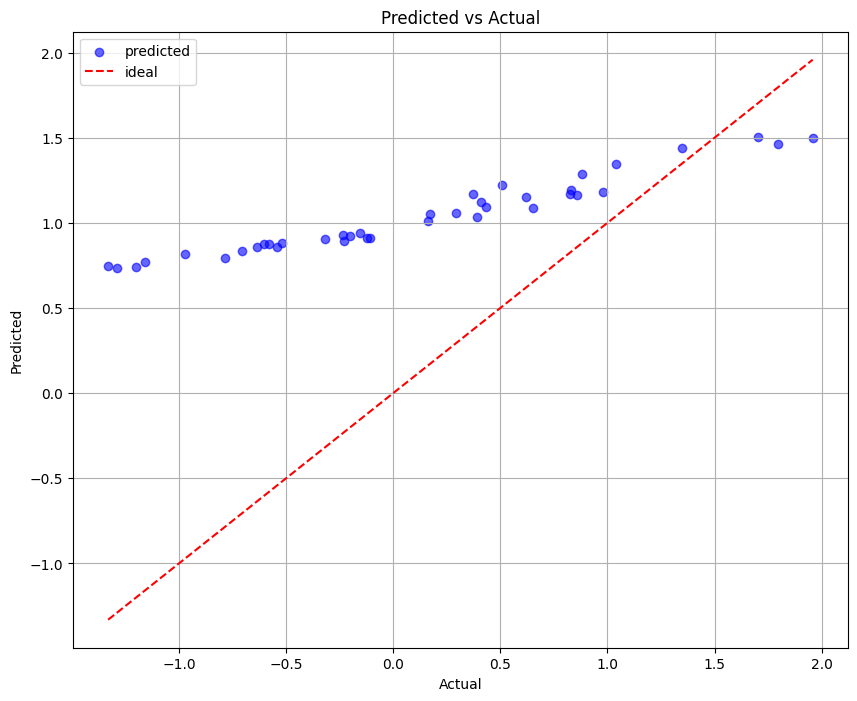

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# -------------------------------------------------------------------
# 10) Optional linear regression on the clean test set  ← NEW / FIXED
# -------------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# y_test_clean, y_pred_clean were built in section 8 bis
if y_test_clean.size == 0:          # just in case every row was filtered out
    print("No valid samples left for linear regression; skipping.")
else:
    sigma      = y_test_clean.ravel()     # true values
    sigma_hat  = y_pred_clean.ravel()     # model predictions

    linreg = LinearRegression()
    linreg.fit(sigma_hat.reshape(-1, 1), sigma)

    r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
    beta_0    = linreg.intercept_
    beta_1    = linreg.coef_[0]

    print(f"Linear-fit R² : {r_squared:.4f}")
    print(f"β₀ (intercept): {beta_0:.6f}")
    print(f"β₁ (slope)    : {beta_1:.6f}")


Linear-fit R² : 0.9811
β₀ (intercept): -0.120490
β₁ (slope)    : 1.081198


### Result


=== Error metrics (lower is better) ===
                        MSE     MAE      R²
Call_EMD_RNN         0.0014  0.0274  0.9749
Call_base_RNN        0.0025  0.0406  0.9812
Call_LSTM_RNN        0.0178  0.1180  0.9276
BS_1d_ATM_Call       0.3619  0.5990  0.9468
LSTM_BS_1d_ATM_Call  0.7245  0.8379  0.6623
EMD_BS_1d_ATM_Call   1.0056  0.9786  0.1527


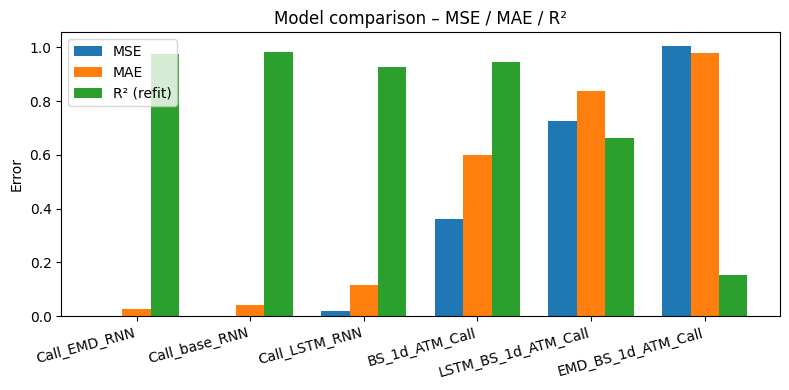

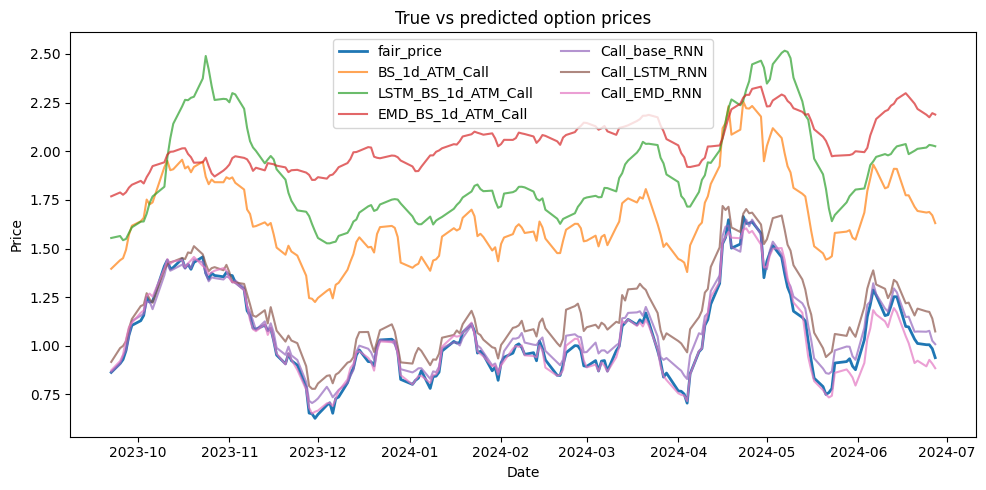

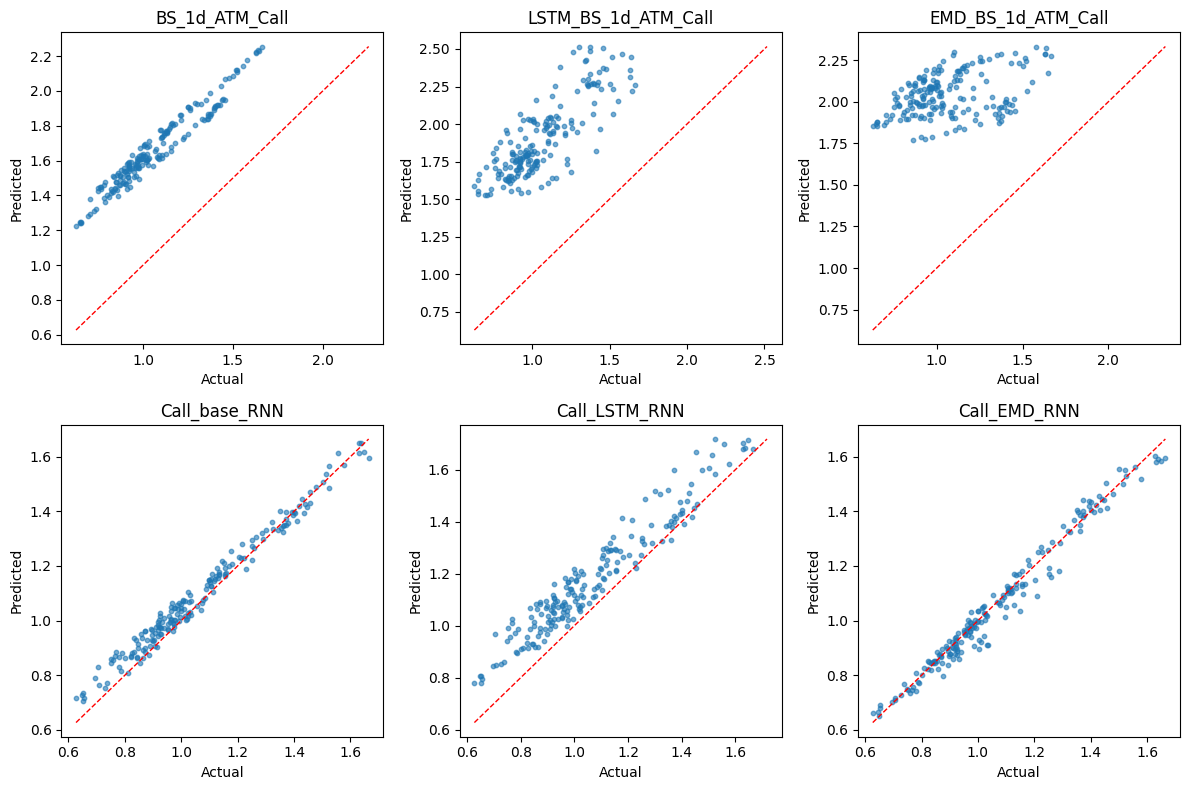

In [17]:
# compare_option_pricing_fixed_r2.py
# ----------------------------------
import pathlib, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

CSV_PATH = pathlib.Path('../../data/dataV.csv')

# -------------------------------------------------------------------
# 1) Load & clean
# -------------------------------------------------------------------
cols_pred = [
    'BS_1d_ATM_Call',
    'LSTM_BS_1d_ATM_Call',
    'EMD_BS_1d_ATM_Call',
    'Call_base_RNN',
    'Call_LSTM_RNN',
    'Call_EMD_RNN'
]
target = 'fair_price'

df = pd.read_csv(CSV_PATH, parse_dates=['Date'])
df_clean = df.dropna(subset=cols_pred + [target]).reset_index(drop=True)

y_true = df_clean[target].values
dates  = df_clean['Date']

# -------------------------------------------------------------------
# 2) Metrics with *refit-R²*
# -------------------------------------------------------------------
metrics = {}
for col in cols_pred:
    y_pred = df_clean[col].values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # ---- R² via linear regression refit (your snippet) -------------
    linreg = LinearRegression()
    linreg.fit(y_pred.reshape(-1, 1), y_true)
    r2 = linreg.score(y_pred.reshape(-1, 1), y_true)

    metrics[col] = {'MSE': mse, 'MAE': mae, 'R²': r2}

# tidy frame
metrics_df = (pd.DataFrame(metrics).T
                .sort_values('MSE')
                .round(4))

print('\n=== Error metrics (lower is better) ===')
print(metrics_df)

# -------------------------------------------------------------------
# 3) Bar chart
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4))
w = 0.25; x = np.arange(len(cols_pred))
ax.bar(x - w, metrics_df['MSE'],  w, label='MSE')
ax.bar(x,       metrics_df['MAE'], w, label='MAE')
ax.bar(x + w, metrics_df['R²'],   w, label='R² (refit)')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df.index, rotation=15, ha='right')
ax.set_ylabel('Error')
ax.set_title('Model comparison – MSE / MAE / R²')
ax.legend()
plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 4) Time-series plot
# -------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(dates, y_true, label='fair_price', linewidth=2)
for col in cols_pred:
    plt.plot(dates, df_clean[col], label=col, alpha=0.7)
plt.title('True vs predicted option prices')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(ncol=2); plt.tight_layout(); plt.show()

# -------------------------------------------------------------------
# 5) Scatter grid (Actual vs Predicted)
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8)); axes = axes.ravel()
for ax, col in zip(axes, cols_pred):
    y_pred = df_clean[col].values
    ax.scatter(y_true, y_pred, alpha=0.6, s=10)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_title(col)
    ax.set_xlabel('Actual'); ax.set_ylabel('Predicted')
plt.tight_layout(); plt.show()


In [18]:
df[['fair_price', 'BS_1d_ATM_Call']].describe().T[['min','mean','max']]


,min,mean,max
fair_price,0.62712,1.059348,1.66462
BS_1d_ATM_Call,1.22490,1.652997,2.25529


In [19]:
df['BS_1d_ATM_Call'].head(15)


0     1.68084
1     1.72726
2     1.81280
3     1.80969
4     1.87009
5     1.82048
6     1.74371
7     1.71638
8     1.63253
9     1.65501
10    1.61028
11    1.48187
12    1.37994
13    1.39408
14    1.30867
Name: BS_1d_ATM_Call, dtype: float64

In [20]:
df['fair_price'].head(15)


0     1.15992
1     1.20461
2     1.29030
3     1.27831
4     1.33899
5     1.28822
6     1.20667
7     1.18055
8     1.09634
9     1.12218
10    1.07385
11    0.93155
12    0.82364
13    0.83844
14    0.73638
Name: fair_price, dtype: float64